# Подготовка

In [ ]:
# Be sure you're using the stable versions of both `tensorflow` and
# `tensorflow-text`, for binary compatibility.
! pip uninstall -y tf-nightly keras-nightly
! pip install tensorflow
! pip install tensorflow-text
! pip install transformers
! pip install pymorphy2
from IPython.display import clear_output
clear_output()

In [ ]:
import numpy as np

In [ ]:
import collections
import pathlib
import re

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_text as tf_text
import transformers as trfs
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
import nltk
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
stopwords = stopwords.words('russian')
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lemmatize(sentence):
    tokens = []
    for token in sentence.split():
        if token and token not in stopwords:
            token = token.strip()
            token = morph.normal_forms(token)[0]

            tokens.append(token)
    if len(tokens) > 0:
        return ' '.join(tokens)
    return ''

In [ ]:
good_pattern = re.compile('[^а-яА-Я ]')
space_pattern = re.compile(' +')


def clean_text(text):
    new_text = good_pattern.sub(' ', text).strip()
    new_text = re.sub(space_pattern, ' ', new_text)
    return new_text

In [ ]:
def normalize(text):
  return lemmatize(clean_text(text.lower()))

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [ ]:
import os
#Change the current working directory to the path of Google Cloud Drive
path="/content/drive/MyDrive/ML"
os.chdir(path)
print(os.listdir(path))
os.chdir('/content')

['backbone_labeled.json', 'backbone_labeled1.json', 'qa_labeled1.json', 'backbone_labeled2.json', 'qa_labeled.json', 'ee66fe54-da44-411e-a67e-19bacd205646.json']


# Импорт данных

In [ ]:
import json
import pandas as pd

js_df = pd.read_json(open("/content/drive/MyDrive/ML/backbone_labeled2.json"))
js_df.to_csv('file.csv')

In [ ]:
def fix(label):
  if label == 2:
    return 0
  return 1

In [ ]:
data = pd.read_csv("file.csv")[:50_000]
data = data.copy().dropna(subset=['text', 'label'])
data['label'] = data['label'].apply(fix)
print(data.head())
print(len(data))

   Unnamed: 0                                               text  label
0           0  подскажите, пожалуйста, как перевести регионал...      1
1           1                             не унывай предет она!!      0
2           2  как женщине которая старше ... как женщине кот...      1
3           3                           купи мне цветочек живой.      0
4           4  что делать если вы пригласили девушку в рестор...      1
50000


In [ ]:
data_features = data.copy()
data_labels = data_features['label']
data_features = data_features['text']

df_train, df_val, dl_train, dl_val = train_test_split(data_features, data_labels, test_size=0.3)

df_val, df_test, dl_val, dl_test = train_test_split(df_val, dl_val, test_size=0.3)

df_train = df_train.apply(normalize)

df_val = df_val.apply(normalize)

df_test = df_test.apply(normalize)


In [ ]:
print(df_train.head())
print(df_train.shape)
print(df_val.head())
print(df_val.shape)
print(df_test.head())
print(df_test.shape)
print(dl_train.head())
print(dl_train.shape)
print(dl_val.head())
print(dl_val.shape)
print(dl_test.head())
print(dl_test.shape)

28459    разница момент выбор пройти делать вывод ситуа...
38198    подсказать сказать мазила отвечать писать ошиб...
31949                      лизнуть зад кулак вернуть назад
31960    нить ващий рено лизинг брать брать почему вопр...
6369                                              общаться
Name: text, dtype: object
(35000,)
40162    сделать лунка река озеро ножик спичка вообще д...
334      почему опустить электрод электролит соединить ...
26521    смотреть девушка отреагировать закрутиться хре...
17534    считать смена аватар ник повлиять характер чел...
20334    дать ситуация возможно сделать октябрь год пол...
Name: text, dtype: object
(10500,)
42601                     истреблять сей пора осознать увы
705      древний человек заметить чёрт разбегаться вид ...
5794     подсказать нужно зарегистрировать грузовой авт...
33737                            призидент анна пуль тчица
2446     повелеть веровать земля прилететь высокий расс...
Name: text, dtype: object
(4500,)
28459    0


In [ ]:
df_train_t = tf.convert_to_tensor(df_train, dtype=tf.string)
dl_train_t = tf.constant(dl_train)
df_val_t= tf.convert_to_tensor(df_val, dtype=tf.string)
dl_val_t = tf.constant(dl_val)
df_test_t = tf.convert_to_tensor(df_test, dtype=tf.string)
dl_test_t = tf.constant(dl_test)
train_dataset = tf.data.Dataset.from_tensor_slices((df_train_t, dl_train_t))
val_dataset = tf.data.Dataset.from_tensor_slices((df_val_t, dl_val_t))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test_t, dl_test_t))

In [ ]:
# Batch the training and testing datasets
batch_size = 32

train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)
validation_steps = len(val_dataset)//batch_size

test_dataset = test_dataset.batch(batch_size)

steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)
print(f"steps_per_epoch: {steps_per_epoch}")
print(f"validation_steps: {validation_steps}")
print(f"train_dataset: {len(train_dataset)}")
print(f"validation_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

steps_per_epoch: 1094
validation_steps: 329
train_dataset: 1094
validation_dataset: 329
test_dataset: 141


In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Тренировка

In [ ]:
VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[200:300]

array(['красивый', 'искать', 'собака', 'мама', 'забыть', 'пройти', 'оно',
       'вроде', 'подарить', 'казаться', 'точно', 'происходить', 'два',
       'помощь', 'несколько', 'магазин', 'использовать', 'себя',
       'отвечать', 'мало', 'причина', 'фото', 'пользоваться', 'лицо',
       'просить', 'ответить', 'тело', 'равно', 'приходить', 'начало',
       'многие', 'сильный', 'цена', 'посоветовать', 'земля', 'желание',
       'диск', 'покупать', 'нормальный', 'находиться', 'назад', 'либо',
       'всякий', 'туда', 'смысл', 'мысль', 'избавиться', 'болеть',
       'получаться', 'мнение', 'никакой', 'к', 'г', 'чувствовать', 'пара',
       'далёкий', 'ситуация', 'школа', 'ночь', 'встречаться', 'прийти',
       'попробовать', 'выбрать', 'удача', 'обязательно', 'л', 'зависеть',
       'пытаться', 'заранее', 'становиться', 'простой', 'кошка',
       'знакомый', 'закон', 'они', 'мужик', 'внимание', 'свет', 'быстро',
       'перестать', 'старый', 'цвет', 'пусть', 'полный', 'имя', 'привет',
     

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
sample_text = ('Простите а как можно отразить сумму кредита в приложении но чтобы он не как трата прошёл?')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.50124234]


In [ ]:
padding = "как " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 652ms/step
[0.50124234]


In [ ]:
checkpoint_path = 'training/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor='val_loss')
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
#from tensorflow.keras import metrics
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          2380352   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
#with tf.device('/device:GPU:0'):
history = model.fit(train_dataset, epochs=20,
                    validation_data=val_dataset,
                    callbacks=[es_callback, cp_callback])

Epoch 1/20
1094/1094 [==============================] - ETA: 0s - loss: 0.4446 - precision: 0.7403 - recall: 0.8788 - binary_accuracy: 0.7843
Epoch 1: val_loss improved from inf to 0.27794, saving model to training/cp.ckpt
1094/1094 [==============================] - 157s 133ms/step - loss: 0.4446 - precision: 0.7403 - recall: 0.8788 - binary_accuracy: 0.7843 - val_loss: 0.2779 - val_precision: 0.8722 - val_recall: 0.8857 - val_binary_accuracy: 0.8798
Epoch 2/20
1094/1094 [==============================] - ETA: 0s - loss: 0.2317 - precision: 0.9038 - recall: 0.9154 - binary_accuracy: 0.9086
Epoch 2: val_loss improved from 0.27794 to 0.27169, saving model to training/cp.ckpt
1094/1094 [==============================] - 136s 124ms/step - loss: 0.2317 - precision: 0.9038 - recall: 0.9154 - binary_accuracy: 0.9086 - val_loss: 0.2717 - val_precision: 0.8827 - val_recall: 0.8866 - val_binary_accuracy: 0.8862
Epoch 3/20
1094/1094 [==============================] - ETA: 0s - loss: 0.1533 - pre

# Результат

In [ ]:
model.load_weights(checkpoint_path)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])
test_loss, test_pre, test_recc, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

141/141 [==============================] - 8s 29ms/step - loss: 0.2823 - precision_1: 0.8729 - recall_1: 0.8794 - binary_accuracy: 0.8753
Test Loss: 0.28232285380363464
Test Accuracy: 0.875333309173584


(0.0, 0.4618715181946754)

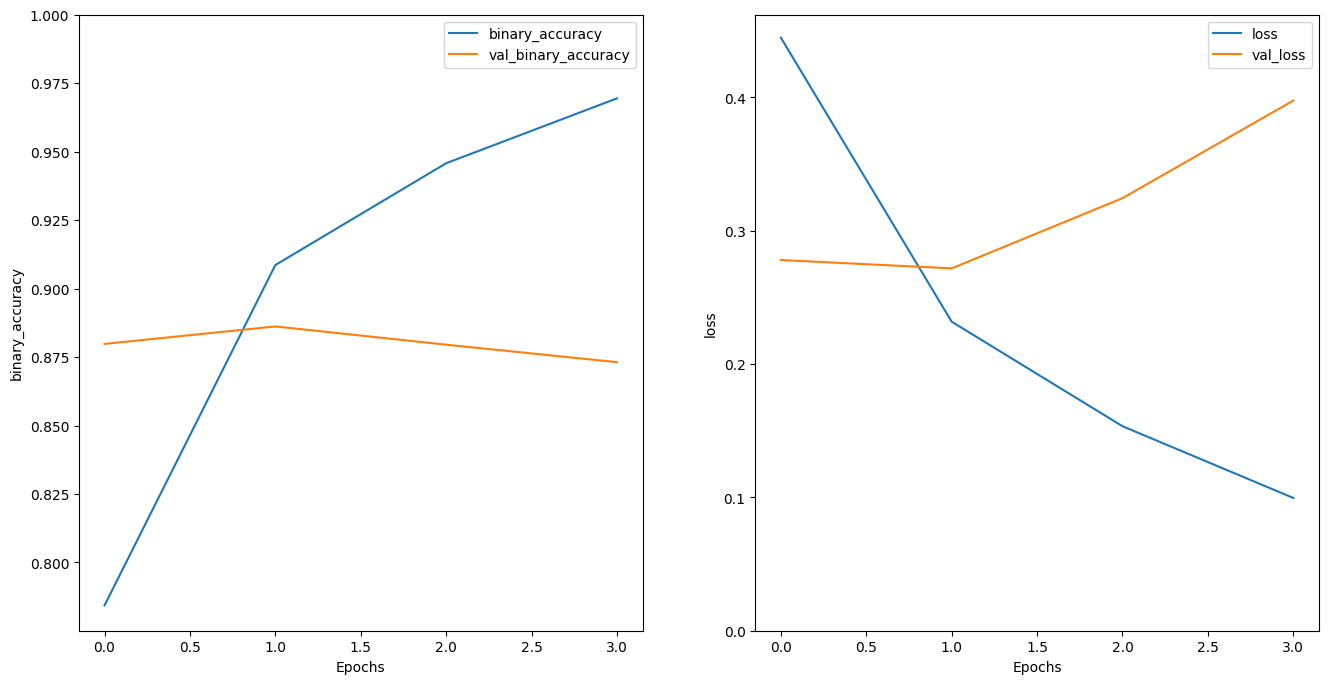

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
def get_real_label(sigmoid_out):
  if sigmoid_out >= 0.5:
    return 1
  else:
    return 0

In [ ]:
def get_real_preds(predictions):
  return np.array(list(map(get_real_label, predictions)))

In [ ]:
sample_text = ['банк тоже не передает знак операции. Тут надо по логам разбираться',
               'Всем привет. После обновления не показывает баланс на вкладке счета. Как решить эту проблему?',
               'Сколько можно задавать одни и те же вопросы?']
predictions = model.predict(np.array(sample_text))
print(get_real_preds(predictions))

1/1 [==============================] - 4s 4s/step
[0 0 0]


In [ ]:
#json_to_check = json.load(open("/content/real_test.json"))
#for row in json_to_check:
#  if row['label'] == 1:
#    row['label'] = 0
#  if row['label'] == 3 or row['label'] == 2:
#    row['label'] = 1

#pd.read_json(json.dumps(json_to_check))

json_data = json.load(open("/content/drive/MyDrive/ML/ee66fe54-da44-411e-a67e-19bacd205646.json"))

questions = []

for row in json_data:
  questions.append({
      'text': row['question']['text'],
      'label': row['is_good_question']
  })

In [ ]:
data_to_check = pd.read_json(json.dumps(questions))
data_to_check = data_to_check.groupby("label").head(min(data_to_check["label"].value_counts()))
print(data_to_check.head())
print(len(data_to_check))

                                                text  label
0  А в чем смысл этой беседы? Здесь можно задават...      0
1  Я прост состою в МФТИшнлй беседе до сих, там у...      0
2  Не, если я буду куратором, то скорее всего я б...      0
3  Добрый день! Даёт ли перечневая олимпиада по и...      1
4  Добрый день.не увидела в списке волонтерскую д...      1
396


In [ ]:
X_check = data_to_check['text'].apply(normalize)
Y_check = data_to_check['label']

In [ ]:
Y_pred1 = model.predict(X_check.to_numpy())
Y_pred = get_real_preds(Y_pred1)
print(Y_pred)

13/13 [==============================] - 0s 21ms/step
[0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report

print(precision_score(Y_check, Y_pred , average="macro"))
print(recall_score(Y_check, Y_pred , average="macro"))
print(f1_score(Y_check, Y_pred , average="macro"))

target_names = ['NO', 'GOOD']
print(classification_report(Y_check, Y_pred, target_names=target_names))

0.7002555094219098
0.6439393939393939
0.617013395888635
              precision    recall  f1-score   support

          NO       0.81      0.38      0.52       198
        GOOD       0.59      0.91      0.72       198

    accuracy                           0.64       396
   macro avg       0.70      0.64      0.62       396
weighted avg       0.70      0.64      0.62       396



# Fine tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_check, Y_check, train_size=0.7, random_state=42)

data_features_tensor= tf.convert_to_tensor(X_train, dtype=tf.string)
data_labels_tensor = tf.constant(y_train)
data_features_tensor_test= tf.convert_to_tensor(X_test, dtype=tf.string)
data_labels_tensor_test = tf.constant(y_test)
train_dataset = tf.data.Dataset.from_tensor_slices((data_features_tensor, data_labels_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((data_features_tensor_test, data_labels_tensor_test))

In [ ]:
# Batch the training and testing datasets
batch_size = 4

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

steps_per_epoch = len(train_dataset)
print(f"steps_per_epoch: {steps_per_epoch}")
print(f"train_dataset: {len(train_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

steps_per_epoch: 70
train_dataset: 70
test_dataset: 30


In [ ]:
checkpoint_path_tune = 'training_fine_tune/cp.ckpt'
cp_callback_tune = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_tune,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1,
                                                 monitor='val_loss')
es_callback_tune = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    callbacks=[cp_callback_tune, es_callback_tune])

Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 0.9137 - precision_2: 0.6272 - recall_2: 0.7626 - binary_accuracy: 0.6534
Epoch 1: val_loss improved from inf to 0.71030, saving model to training_fine_tune/cp.ckpt
70/70 [==============================] - 21s 134ms/step - loss: 0.9137 - precision_2: 0.6272 - recall_2: 0.7626 - binary_accuracy: 0.6534 - val_loss: 0.7103 - val_precision_2: 0.6825 - val_recall_2: 0.7288 - val_binary_accuracy: 0.6975
Epoch 2/20
69/70 [============================>.] - ETA: 0s - loss: 0.6509 - precision_2: 0.6892 - recall_2: 0.7338 - binary_accuracy: 0.6993
Epoch 2: val_loss improved from 0.71030 to 0.66038, saving model to training_fine_tune/cp.ckpt
70/70 [==============================] - 5s 72ms/step - loss: 0.6505 - precision_2: 0.6892 - recall_2: 0.7338 - binary_accuracy: 0.7004 - val_loss: 0.6604 - val_precision_2: 0.6769 - val_recall_2: 0.7458 - val_binary_accuracy: 0.6975
Epoch 3/20
70/70 [==============================] - ETA: 0s 

30/30 [==============================] - 3s 7ms/step - loss: 0.6337 - precision_3: 0.6818 - recall_3: 0.7627 - binary_accuracy: 0.7059
Test Loss: 0.6336597204208374
Test Accuracy: 0.7058823704719543
Test Precision: 0.6818181872367859
Test Recall: 0.7627118825912476


(0.0, 0.937748073041439)

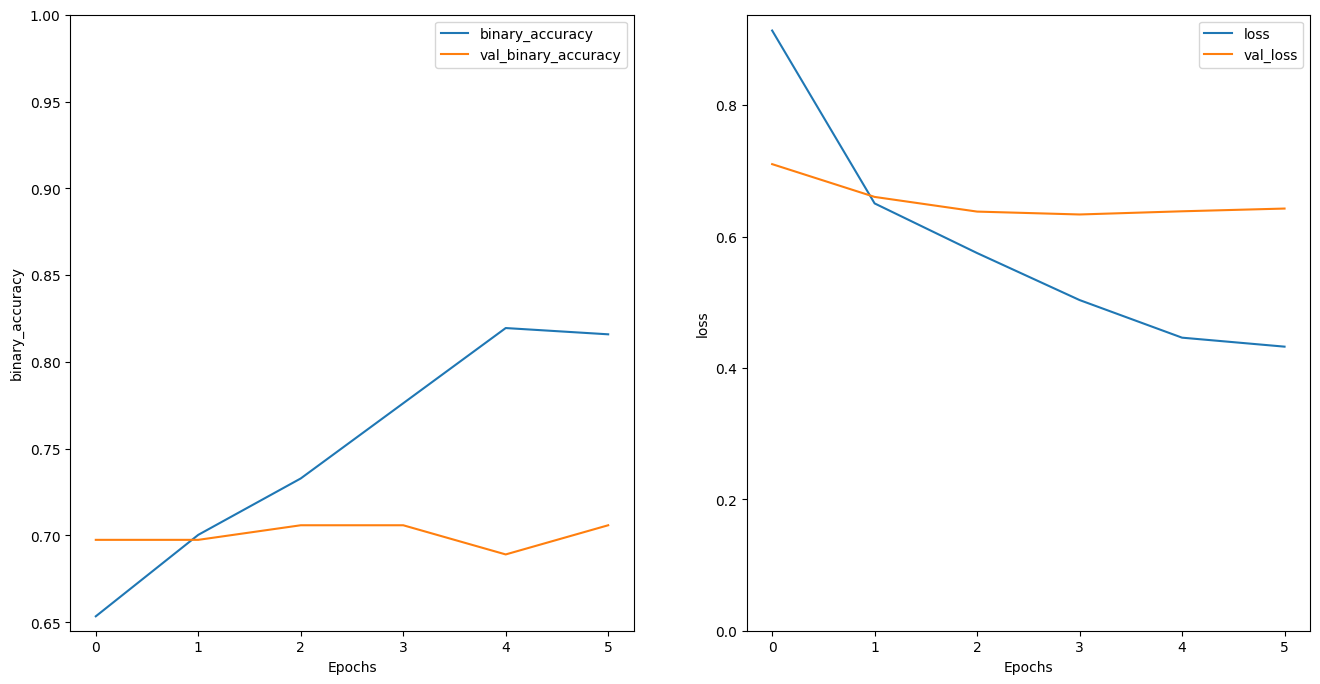

In [ ]:
model.load_weights(checkpoint_path_tune)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()])

test_loss, test_pre, test_recc, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', test_pre)
print('Test Recall:', test_recc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
Y_pred1 = model.predict(X_test.to_numpy())
Y_pred = get_real_preds(Y_pred1)
print(Y_pred)

print(precision_score(y_test, Y_pred , average="macro"))
print(recall_score(y_test, Y_pred , average="macro"))
print(f1_score(y_test, Y_pred , average="macro"))

4/4 [==============================] - 4s 34ms/step
[0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0
 0 1 1 1 1 1 0 0]
0.7088336192109777
0.7063559322033899
0.7051327433628318


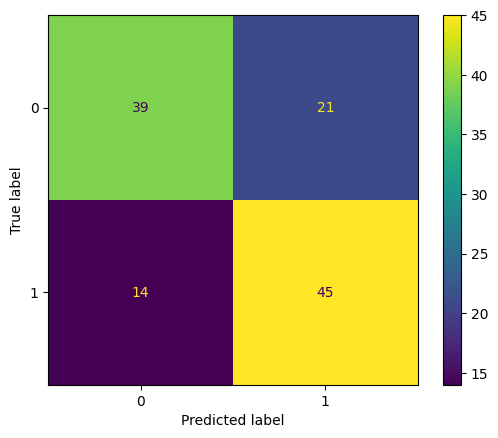

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_real = confusion_matrix(y_test, Y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_real, display_labels=[0, 1])
disp.plot()
plt.show()

In [ ]:

target_names = ['NO', 'GOOD']
print(classification_report(y_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.74      0.65      0.69        60
        GOOD       0.68      0.76      0.72        59

    accuracy                           0.71       119
   macro avg       0.71      0.71      0.71       119
weighted avg       0.71      0.71      0.71       119

